In [29]:
%matplotlib inline

In [30]:
from glob import glob

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [32]:
from matplotlib import style
style.use('ggplot')

In [33]:
# l = !ls ../data/hourly_data_nc/

In [34]:
def make_title(station):
    name = geodata.ix[int(station)]['NOM_USUEL']
    lon = geodata.ix[int(station)]['LON_DG']
    lat = geodata.ix[int(station)]['LAT_DG']
    alt = geodata.ix[int(station)]['ALTI']
    title = "{}: [{:4.2f}E / {:4.2f}S], {:4.2f} m.".format(name, lon, lat, alt)
    return lat, lon, title

In [35]:
def harmo(data, nharm=2, variance=True): 
    import pandas as pd
    import numpy as np
    if isinstance(data, pd.core.frame.Series) or isinstance(data, pd.core.frame.DataFrame): 
        index = data.index
        data_values = data.values.flatten()
    else: 
        data_values = data
    fft=np.fft.rfft(data_values)
    fft[nharm+1]=0.5*fft[nharm+1]
    fft[nharm+2:]=0
    data_f=np.fft.irfft(fft)
    var = np.corrcoef(data_values, data_f)[0,1] ** 2 * 100
    if isinstance(data, pd.core.frame.Series): 
        data_f = pd.Series(data_f, index=index)
    if isinstance(data, pd.core.frame.DataFrame):
        data_f = pd.DataFrame(data_f, index=index, columns=['Fourier_{}harms'.format(nharm)])
    if variance:
        return data_f, var
    else: 
        return data_f

In [36]:
# for f in l: 
#     print("processing {}".format(f))
#     data = pd.read_csv('../data/hourly_data_nc/{}'.format(f), sep=';', \
#                        header=None, parse_dates = {'date': [1, 2, 3, 4]}, \
#                        index_col='date')
#     data.columns = ['station', 'rain', 'code']
#     data.to_csv('../data/{}.csv'.format(f[:-4]))
#     del(data)

In [37]:
geodata = pd.read_csv('../data/geo.csv', index_col=0, sep=';')

In [38]:
geodata[geodata.NOM_USUEL == 'POINDIMIE']

,NOM_USUEL,LON_DG,LAT_DG,LAMBX_100,LAMBY_100,ALTI
NUM_POSTE,,,,,,
98822001,POINDIMIE,165.328,-20.9325,3301.03,3626.73,14


In [39]:
lfiles = glob('../data/98*.csv')

In [40]:
station_subset = []
for f in lfiles: 
    station_subset.append(int(f.split('/')[-1][:-4]))

In [41]:
geodata = geodata.ix[station_subset]

In [44]:
# geodata.to_csv('../data/geo_subset.csv')

In [14]:
w = 6
h = 4 
res = 80

In [15]:
var_explained = geodata.loc[:,['LON_DG','LAT_DG']]

In [16]:
var_explained.loc[:,'var_explained'] = np.nan

In [25]:
all_mean_cycles_f = pd.DataFrame([], index=range(23))

In [26]:
for f in lfiles: 
    station = f.split('/')[-1][:-4]
    in_station = int(station)
    lat, lon, title = make_title(station)
    data = pd.read_csv(f, parse_dates=True, engine='python', index_col='date')
    datan = data.copy()
    datan.replace({'rain': {0: np.nan}}, inplace=True)
    # datan.dropna(inplace=True)
    # rainfall frequency per hour (count of *non-zero rainfall*)
    freq_cycle = datan.groupby(datan.index.hour)[['rain']].count() / len(datan.dropna()) * 100
    # freq_cycle = datan.groupby(datan.index.hour)[['rain']].count() / len(datan) * 100
    freq_cycle_f, var_freq = harmo(freq_cycle, nharm=2)
    # rainfall average per hour
    datann = datan.dropna()
    # mean_cycle = datann.groupby(datann.index.hour)[['rain']].median()
    mean_cycle = datann.groupby(datann.index.hour)[['rain']].mean()
    mean_cycle_f, var_mean = harmo(mean_cycle, nharm=2)
    all_mean_cycles_f.loc[:,in_station] = mean_cycle_f
    var_explained.loc[in_station,'var_explained'] = var_mean
    # plots
    fig, ax1 = plt.subplots(figsize=(w,h))
    fig.subplots_adjust(right=0.85)
    ax2 = ax1.twinx()
    ax1.plot(freq_cycle_f, 'r', label='frequency: {:4.2f}%'.format(var_freq), lw=3)
    ax2.plot(mean_cycle_f, 'b', label='intensity: {:4.2f}%'.format(var_mean), lw=3)
    ax1.plot(freq_cycle, 'r--', lw=1)
    ax2.plot(mean_cycle, 'b--', lw=1)
    ax1.legend()
    ax2.legend(loc=4)
    ax1.set_ylabel('frequency (%)')
    ax2.set_ylabel('intensity (mm)')
    ax1.set_xlim(0,23)
    ax1.set_xlabel('hour')
    ax1.set_title("Station No. {}\n{}".format(station, title), fontsize=12)
    fig.savefig('../www/{}.png'.format(station), dpi=res)
    plt.close(fig)

In [18]:
lat = var_explained.LAT_DG.values
lon = var_explained.LON_DG.values
varexp = var_explained.var_explained.values

In [19]:
from mpl_toolkits.basemap import Basemap as bm

In [20]:
m = bm(projection='cyl', llcrnrlat=lat.min()-0.25, urcrnrlat=lat.max()+0.25, \
       llcrnrlon=lon.min()-0.25, urcrnrlon=lon.max()+0.25, resolution='f')

In [21]:
style.use('classic')

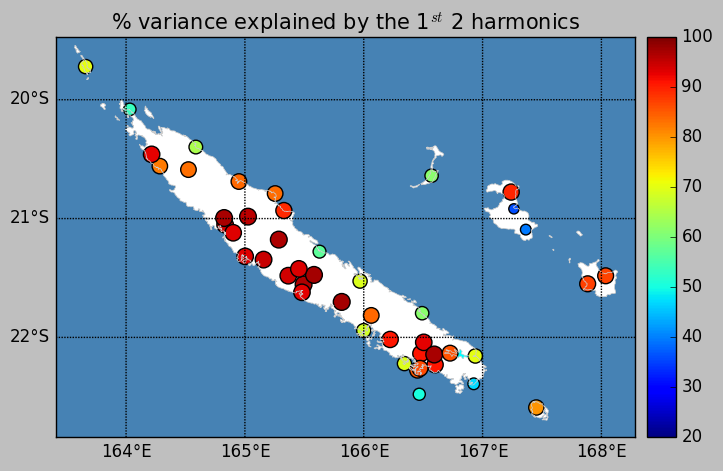

In [22]:
f, ax = plt.subplots(figsize=(8,6))
m.ax = ax

m.drawmapboundary(fill_color='steelblue', zorder=-1)
m.fillcontinents(color='w',lake_color='aqua', zorder=-1)


m.drawcoastlines(color='0.8',linewidth=0.5)

im = m.scatter(lon,lat,s=varexp*1.5, c=varexp, vmin=20, vmax=100)

m.drawparallels(np.arange(-90.,90.,1), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,1), labels=[0,0,0,1]); 

m.colorbar(im)

ax.set_title('% variance explained by the 1$^{st}$ 2 harmonics', fontsize=15)

f.savefig('../figures/map_var_explained_2harm.png', dpi=200)

In [28]:
all_mean_cycles_f.to_csv('../outputs/all_mean_cycles_f.csv')